In [2]:
# Importing PyTorch library
import torch
from torch import nn

print(torch.__version__)

# Automatically select the best available device: CUDA if available, else MPS (for macOS), else CPU.
device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")

device

2.4.1


device(type='mps')

# 1. Working with MNIST Dataset [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST)

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(root='data', 
                            download=True, 
                            train=True, 
                            transform=ToTensor(), 
                            target_transform=None)

test_data = datasets.MNIST(root='data', 
                           download=True, 
                           train=False, 
                           transform=ToTensor(), 
                           target_transform=None)

# Checking the number of samples in training and test datasets
len(train_data), len(test_data)

(60000, 10000)

### 1.1 - Visualizing random samples from the MNIST training dataset

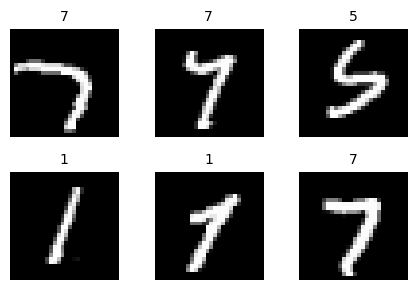

In [6]:
import matplotlib.pyplot as plt

torch.manual_seed(42)

fig = plt.figure(figsize=(5, 3))
rows, cols = 2, 3

# Plotting random images with labels
for i in range(rows*cols):
    random_idx = torch.randint(1, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]

    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"{label}", fontsize=10)
    plt.axis(False)
    plt.tight_layout()

### 1.2 - Creating data loaders for training and testing datasets

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(1875, 313)

### 1.3 - Creating our NN Model for Image Classification

In [10]:
class MNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)

        return x


class_names = train_data.classes

input_shape = 1
hidden_units = 10
output_shape = len(class_names)


model = MNISTModel(input_shape=input_shape, 
                   hidden_units=hidden_units, 
                   output_shape=output_shape)
model

MNISTModel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 1.4 - Downloading the helper_functions file (contains accuracy and plotting functions)

In [12]:
# Downlading helper_functions file (Accuracy and Plotting)
from pathlib import Path
import requests

file_name = 'helper_functions.py'
file_url = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py'

if Path(file_name).is_file():
    print(f"{file_name} already exists, skipping download...")
else:
    request = requests.get(file_url)
    with open(file_name, 'wb') as file:
        file.write(request.content)
        print(f"{file_name} as been downloaded successfully...")

helper_functions.py already exists, skipping download...


In [13]:
from helper_functions import accuracy_fn
from tqdm import tqdm
from timeit import default_timer as timer

# Function to train the model on the specified device
def train_model(model: nn.Module, 
                dataloader: torch.utils.data.DataLoader, 
                device: torch.device):

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

    epochs = 5
    train_start_time = timer()
    
    for epoch in tqdm(range(epochs), desc=f'Model is getting trained on {device}'):
        train_loss = 0
        train_acc = 0

        epoch_start_time = timer()     # Training time starts
        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        train_loss /= len(dataloader)
        train_acc /= len(dataloader)

        test_loss = 0
        test_acc = 0

        model.eval()
        with torch.inference_mode():
            for batch, (X, y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                test_loss += loss
                test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

            test_loss /= len(dataloader)
            test_acc /= len(dataloader)

        epoch_end_time = timer()     # Training time ends
        epoch_total_time = epoch_end_time - epoch_start_time

        print(f"Epoch {epoch+1} - Time: {epoch_total_time:.2f}s | Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")

    train_end_time = timer()
    train_total_time = train_end_time - train_start_time
    
    return {'Train Loss': f"{train_loss:.4f}", 
            'Test Loss': f"{test_loss:.4f}", 
            'Train Accuracy': f"{train_acc:.2f}%", 
            'Test Accuracy': f"{test_acc:.2f}%",
            'Time taken': f"{train_total_time:.2f}s",
            'Device': device}

### 1.5 - Examine the training performance on GPU

In [15]:
train_on_gpu = train_model(model=model.to(device), 
                           dataloader=train_dataloader, 
                           device=device)
train_on_gpu

Model is getting trained on mps:  20%|██▍         | 1/5 [00:15<01:00, 15.11s/it]

Epoch 1 - Time: 15.11s | Train Loss: 0.3514, Accuracy: 87.96% | Test Loss: 0.0863, Accuracy: 97.26%


Model is getting trained on mps:  40%|████▊       | 2/5 [00:27<00:39, 13.26s/it]

Epoch 2 - Time: 11.96s | Train Loss: 0.0830, Accuracy: 97.48% | Test Loss: 0.0626, Accuracy: 97.99%


Model is getting trained on mps:  60%|███████▏    | 3/5 [00:38<00:25, 12.65s/it]

Epoch 3 - Time: 11.90s | Train Loss: 0.0619, Accuracy: 98.08% | Test Loss: 0.0443, Accuracy: 98.56%


Model is getting trained on mps:  80%|█████████▌  | 4/5 [00:50<00:12, 12.36s/it]

Epoch 4 - Time: 11.91s | Train Loss: 0.0513, Accuracy: 98.40% | Test Loss: 0.0409, Accuracy: 98.67%


Model is getting trained on mps: 100%|████████████| 5/5 [01:02<00:00, 12.57s/it]

Epoch 5 - Time: 11.92s | Train Loss: 0.0442, Accuracy: 98.62% | Test Loss: 0.0355, Accuracy: 98.90%


{'Train Loss': '0.0442',
 'Test Loss': '0.0355',
 'Train Accuracy': '98.62%',
 'Test Accuracy': '98.90%',
 'Time taken': '62.86s',
 'Device': device(type='mps')}

### 1.6 - Examine the training performance on CPU

In [17]:
cpu = torch.device('cpu')
train_on_cpu = train_model(model=model.to(cpu), 
                           dataloader=train_dataloader, 
                           device=cpu)
train_on_cpu

Model is getting trained on cpu:  20%|██▍         | 1/5 [00:35<02:22, 35.54s/it]

Epoch 1 - Time: 35.54s | Train Loss: 0.0398, Accuracy: 98.72% | Test Loss: 0.0366, Accuracy: 98.84%


Model is getting trained on cpu:  40%|████▊       | 2/5 [01:11<01:47, 35.80s/it]

Epoch 2 - Time: 35.98s | Train Loss: 0.0361, Accuracy: 98.85% | Test Loss: 0.0330, Accuracy: 98.94%


Model is getting trained on cpu:  60%|███████▏    | 3/5 [01:46<01:11, 35.61s/it]

Epoch 3 - Time: 35.36s | Train Loss: 0.0326, Accuracy: 98.97% | Test Loss: 0.0284, Accuracy: 99.04%


Model is getting trained on cpu:  80%|█████████▌  | 4/5 [02:23<00:35, 35.99s/it]

Epoch 4 - Time: 36.57s | Train Loss: 0.0304, Accuracy: 99.00% | Test Loss: 0.0230, Accuracy: 99.25%


Model is getting trained on cpu: 100%|████████████| 5/5 [02:58<00:00, 35.68s/it]

Epoch 5 - Time: 34.92s | Train Loss: 0.0279, Accuracy: 99.10% | Test Loss: 0.0216, Accuracy: 99.31%


{'Train Loss': '0.0279',
 'Test Loss': '0.0216',
 'Train Accuracy': '99.10%',
 'Test Accuracy': '99.31%',
 'Time taken': '178.41s',
 'Device': device(type='cpu')}

### 1.7 - Visualzing GPU and CPU model results in a Table

In [19]:
import pandas as pd

results = pd.DataFrame([train_on_gpu, train_on_cpu])
results

,Train Loss,Test Loss,Train Accuracy,Test Accuracy,Time taken,Device
0,0.0442,0.0355,98.62%,98.90%,62.86s,mps
1,0.0279,0.0216,99.10%,99.31%,178.41s,cpu


### 1.8 - Making Prediction using trained model and visualizing the random data and comparing the prediction to the target labels

In [21]:
# Making predictions using the trained model
def make_predictions(model: nn.Module, 
                     dataloader: torch.utils.data.DataLoader, 
                     accuracy_fn: None,
                     device: torch.device):

    y_preds = []
    accuracy = 0
    
    loss_fn = nn.CrossEntropyLoss()

    model.eval()    # Set the model to evaluation mode
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            y_logit = model(X.to(device))
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            accuracy += accuracy_fn(y_true=y.to(device), y_pred=y_pred)
            y_preds.append(y_pred)   # Store the predictions
            
        accuracy /= len(dataloader)
        print(f"Test accuracy is {accuracy:.2f}%")
        
    return torch.cat(y_preds)

predictions = make_predictions(model=model.to(device), 
                               dataloader=test_dataloader, 
                               accuracy_fn=accuracy_fn,
                               device=device)
predictions, predictions.shape

Test accuracy is 98.64%


(tensor([7, 2, 1,  ..., 4, 5, 6], device='mps:0'), torch.Size([10000]))

### 1.9 - Comparing 25 random test images with their true and predicted labels

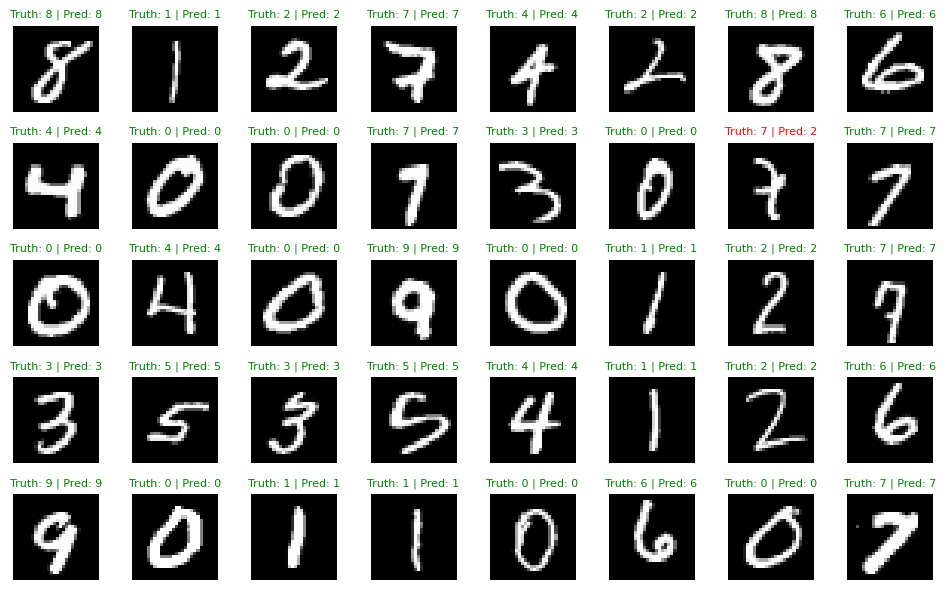

In [23]:
# torch.manual_seed(42)

fig = plt.figure(figsize=(10, 6))
rows, cols = 5, 8

for i in range(rows*cols):
    random_idx = torch.randint(1, len(test_data), size=[1]).item()
    image, label = test_data[random_idx]
    
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Truth: {label} | Pred: {predictions[random_idx]}", 
              fontsize=8, 
              c='green' if label==predictions[random_idx] else 'red')
    
    plt.axis(False)
    plt.tight_layout()

### 1.10 - Plot a confusion matrix comparing your model's predictions to the truth labels

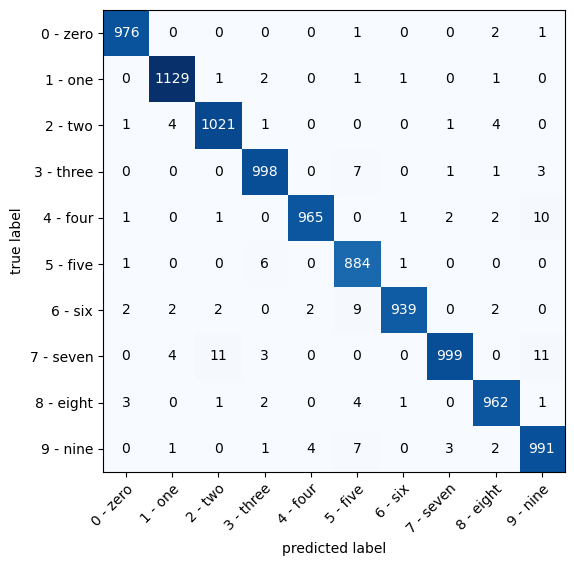

In [25]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Create a ConfusionMatrix object for multi-class classification
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass').to(device)

# Compute the confusion matrix tensor
confmat_tensor = confmat(preds=predictions.to(device), 
                         target=test_data.targets.to(device))

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.cpu().numpy(), 
                                class_names=class_names, 
                                figsize=(6, 6))

### 1.11 - Testing the output shape of a Conv2D layer with a random tensor

In [27]:
random_tensor = torch.randn(size=(1, 3, 64, 64))

nnLayer = nn.Conv2d(in_channels=3, 
                    out_channels=64, 
                    kernel_size=3, 
                    padding=1, 
                    stride=1)

print(f"Tensor shape before: {random_tensor.shape}")

nn_random_tensor = nnLayer(random_tensor)

print(f"Tensor shape after: {nn_random_tensor.shape}")

Tensor shape before: torch.Size([1, 3, 64, 64])
Tensor shape after: torch.Size([1, 64, 64, 64])


# 2. Working with FashionMNIST Dataset

### 2.1 - Importing and loading FashionMNIST dataset for training and testing

In [30]:
train_data = datasets.FashionMNIST(root='data', 
                                  train=True, 
                                  download=True, 
                                  transform=ToTensor(), 
                                  target_transform=None)

test_data = datasets.FashionMNIST(root='data', 
                                  train=False, 
                                  download=True, 
                                  transform=ToTensor(), 
                                  target_transform=None)
len(train_data), len(test_data)

(60000, 10000)

### 2.2 - Creating DataLoaders for the FashionMNIST training and test datasets

In [32]:
BATCH_SIZE = 32

# DataLoader for training data
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)

# DataLoader for test data
test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(1875, 313)

### 2.3 - Reusing our previous model and initializing for FashionMNIST model

In [34]:
class_names = test_data.classes

input_shape = 1
hidden_units = 10
output_shape = len(class_names)

# Initialize the MNISTModel with specified parameters and move it to the device
model = MNISTModel(input_shape=input_shape, 
                   hidden_units=hidden_units, 
                   output_shape=output_shape).to(device)
model

MNISTModel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 2.4 - Training FashionMNIST model

In [36]:
from tqdm import tqdm
from torchmetrics import Accuracy
from timeit import default_timer as timer

# Define accuracy function, loss function and optimizer
accuracy_fn = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

training_starts = timer()      # Timer to find total training time - start

def train_fashionmnist(model: nn.Module, dataloader: torch.utils.data.DataLoader, device: torch.device):
    epochs = 5
    for epoch in tqdm(range(epochs), desc=f"Model is getting trained on {device}"):
    
        train_loss, train_acc = 0, 0
        test_loss, test_acc = 0, 0
    
        epoch_time_start = timer()      # Timer to find EPOCH training time - start
    
        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            train_loss += loss
            train_acc += accuracy_fn(y_pred, y)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
    
        # Evaluate the model on test data
        model.eval()
        with torch.inference_mode():
            for batch, (X, y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                
                loss = loss_fn(y_pred, y)
                test_loss += loss
    
                test_acc += accuracy_fn(y_pred, y)
    
            test_loss /= len(train_dataloader)
            test_acc /= len(train_dataloader)
        
        epoch_time_end = timer()      # Timer to find EPOCH training time - end
        total_epoch_time = epoch_time_end - epoch_time_start
    
        print(f"Epoch{epoch+1} took {total_epoch_time:.2f}s| Train loss: {train_loss:.4f} - Train accuracy: {train_acc*100:.2f}% | Test loss: {test_loss:.4f} - Test accuracy: {test_acc*100:.2f}%")
    
        
    training_ends = timer()      # Timer to find total training time - end
    total_training_time = training_ends - training_starts
    
    print(f"\nFashionMNIST training took {total_training_time:.2f}s")

    return {
        'Train Loss': f"{train_loss:.4f}",
        'Train Accuracy': f"{train_acc*100:.2f}%",
        'Test Loss': f"{test_loss:.4f}",
        'Test Accuracy': f"{test_acc*100:.2f}%",
        'Training Time': f"{total_training_time:.2f}s",
        'Device': device
    }

# Train the model and capture the results
fashionmnist_results = train_fashionmnist(model=model.to(device), 
                                          dataloader=train_dataloader, 
                                          device=device)
fashionmnist_results

Model is getting trained on mps:  20%|██▍         | 1/5 [00:14<00:56, 14.08s/it]

Epoch1 took 14.06s| Train loss: 0.5530 - Train accuracy: 80.28% | Test loss: 0.3506 - Test accuracy: 87.43%


Model is getting trained on mps:  40%|████▊       | 2/5 [00:27<00:41, 13.75s/it]

Epoch2 took 13.51s| Train loss: 0.3457 - Train accuracy: 87.54% | Test loss: 0.3115 - Test accuracy: 88.67%


Model is getting trained on mps:  60%|███████▏    | 3/5 [00:41<00:27, 13.64s/it]

Epoch3 took 13.50s| Train loss: 0.3115 - Train accuracy: 88.73% | Test loss: 0.2954 - Test accuracy: 89.24%


Model is getting trained on mps:  80%|█████████▌  | 4/5 [00:54<00:13, 13.73s/it]

Epoch4 took 13.86s| Train loss: 0.2933 - Train accuracy: 89.33% | Test loss: 0.2793 - Test accuracy: 89.97%


Model is getting trained on mps: 100%|████████████| 5/5 [01:09<00:00, 13.97s/it]

Epoch5 took 14.87s| Train loss: 0.2804 - Train accuracy: 89.81% | Test loss: 0.3099 - Test accuracy: 88.72%

FashionMNIST training took 69.87s


{'Train Loss': '0.2804',
 'Train Accuracy': '89.81%',
 'Test Loss': '0.3099',
 'Test Accuracy': '88.72%',
 'Training Time': '69.87s',
 'Device': device(type='mps')}

In [37]:
pd.DataFrame([fashionmnist_results])

,Train Loss,Train Accuracy,Test Loss,Test Accuracy,Training Time,Device
0,0.2804,89.81%,0.3099,88.72%,69.87s,mps


### 2.5 - Making predictions with the trained FashionMNIST model

In [39]:
from torchmetrics import Accuracy

accuracy_fn = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

def make_predictions(model: nn.Module, dataloader: torch.utils.data.DataLoader, device: torch.device):
    y_preds = []
    
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            y_logit = model(X)
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            
            y_preds.append(y_pred)
    
    return torch.cat(y_preds)       # Combine all predictions into a single tensor

# Generate predictions from the test DataLoader
predictions = make_predictions(model=model.to(device), 
                               dataloader=test_dataloader, 
                               device=device)

len(predictions)
predictions[:10], test_data.targets[:10]

(tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], device='mps:0'),
 tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]))

### 2.6 - Visualizing random test images with predicted and true labels

Truth | Predicted


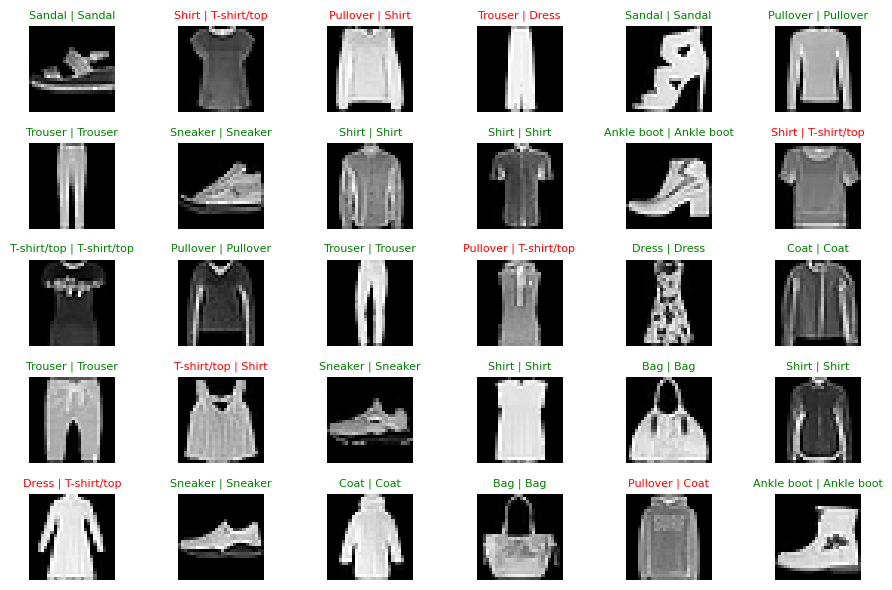

In [41]:
# Visualize 25 items from test data and compare the Pred and Truth labels

fig = plt.figure(figsize=(10, 6))
rows, cols = 5, 6

for i in range(rows*cols):
    random_idx = torch.randint(1, len(test_data), size=[1]).item()
    image, label = test_data[random_idx]

    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"{class_names[label]} | {class_names[predictions[random_idx]]}", 
              fontsize=8, 
              c='green' if label==predictions[random_idx] else 'red')
    plt.axis(False)
    plt.tight_layout()

print(f"Truth | Predicted")

### 2.6 - Visualizing the Confusion Matrix for the FashionMNIST model

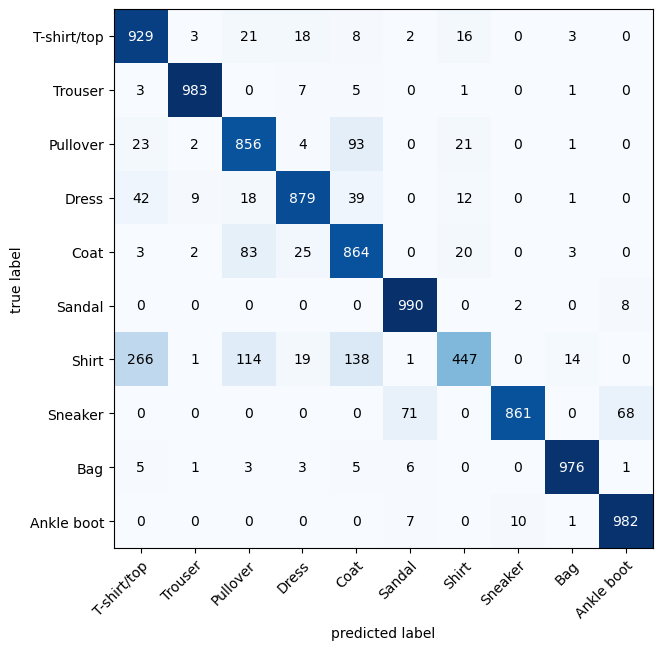

In [43]:
# Visualize the ConfusionMatrix
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Initialize ConfusionMatrix metric
confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names)).to(device)

# Compute the confusion matrix
confmat_tensor = confmat(preds=predictions.to(device), 
                         target=test_data.targets.to(device))

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.cpu().numpy(),   # Convert tensor to numpy array for plotting
    class_names = class_names,
    figsize = (7, 7)
)